In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from imblearn.over_sampling import RandomOverSampler
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.exceptions import ConvergenceWarning
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
import itertools
import seaborn as sns
import warnings

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [4]:
models = list(zip(
    [
        "Logistic Regression", 
        "SVC (Linear)", 
        "SVC (RBF)", 
        "Random Forest"
    ],
    [
        LogisticRegression(solver = 'saga', fit_intercept = True, random_state = 42, n_jobs = 1),
        SVC(kernel = "linear", random_state = 42),
        SVC(kernel = "rbf", random_state = 42),
        RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs = 1)
    ]
))

In [5]:
from load_adult import EXPORTED_DATASET
preprocess_dataset, dataset, Y_VAR = EXPORTED_DATASET
preprop = preprocess_dataset(dataset)

Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.


# Goals

- Test causal relationships to infer predictivity of variables
- Test variable ordinal ordering to find
    1. Maximially suboptimial ordering
    2. Random orderings
    3. Optimal orderings


4 Phases

1 phase per day


Today we will implement the maximally suboptimal ordering

In [6]:
y_data = preprop[0][Y_VAR]


def reorder(input_data, ordering):
    mapping = {x: y for x, y in enumerate(ordering)}
    return np.vectorize(lambda x: mapping[x])(input_data)

def test_all_permutations(feature, goal, model, trials=None):
    default_label_encoded = OrdinalEncoder().fit_transform(preprop[2][feature].reshape(-1,1)).astype(int)
    all_labels = list(range(np.max(default_label_encoded) + 1))

    
    data = []
    
    
    def run_trial(p):
        ordered_data = reorder(default_label_encoded, p)
        
        X_train, X_test, y_train, y_test = train_test_split(ordered_data, y_data, test_size=0.3)
        
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        
        score = goal(y_test, y_pred)
        data.append({
            "permutation": p,
            "score": score
        })
    
    if trials != None:
        for _ in range(trials):
            p = np.random.permutation(all_labels)
            run_trial(p)
    else:
        for p in itertools.permutations(all_labels):
            run_trial(p)
        
        
        
    return pd.DataFrame(data)

ordering_results = test_all_permutations("relationship", balanced_accuracy_score, models[0][1])

    

In [7]:
ordering_results.sort_values(by="score", ascending=False)

,permutation,score
189,"(1, 3, 5, 2, 4, 0)",0.534499
321,"(2, 4, 1, 3, 5, 0)",0.534054
305,"(2, 3, 4, 5, 1, 0)",0.534008
398,"(3, 1, 4, 2, 0, 5)",0.533735
408,"(3, 2, 0, 1, 4, 5)",0.533515
...,...,...
547,"(4, 2, 5, 0, 3, 1)",0.482452
315,"(2, 4, 0, 3, 5, 1)",0.482327
195,"(1, 4, 0, 3, 5, 2)",0.481840
404,"(3, 1, 5, 2, 0, 4)",0.481621


In [8]:
def plot_permutation(feature, permutation):
    default_label_encoded = OrdinalEncoder().fit_transform(preprop[2][feature].reshape(-1,1)).astype(int).flatten()
    x = reorder(default_label_encoded, permutation)
    # plt.scatter(x, y_data)
    data = pd.DataFrame({
        "x": x,
        "y": y_data
    })
    
    model = LogisticRegression().fit(x.reshape(-1,1), y_data)
    
    b = model.intercept_[0]
    w = model.coef_.T
    
    # plot rates for each class
    rates = []
    classes = []
    for c in data["x"].unique():
        classes.append(c)
        rates.append(np.mean(y_data[x == c]))
        # print(c, np.mean(y_data[x == c]))
        
    plt.scatter(classes, rates)
    
    # sns.violinplot(data, x="x", y="y")
    # plt.xticks(labels=permutation)
    plt.plot(np.repeat([-b/w], 10), np.linspace(0, 1, 10))
    plt.plot(np.linspace(0, max(classes), 10), np.repeat([0.5], 10))
    plt.show()


In [9]:
def inverse_perm(p):
    return np.arange(len(p))[np.argsort(p)]

def reorder(input_data, ordering):
    mapping = {x: y for x, y in enumerate(ordering)}
    return np.vectorize(lambda x: mapping[x])(input_data)

def target_encode(feature, train_index):
    x = OrdinalEncoder().fit_transform(preprop[2][feature].reshape(-1,1)).astype(int).flatten()
    rates = []
    classes = []
    for c in np.unique(x):
        classes.append(c)
        mask = x == c
        filtered_train = train_index[mask[train_index]]
        rates.append(np.mean(y_data[filtered_train]))
        
    rates = np.nan_to_num(rates)
    
              
    return reorder(
        x,
        inverse_perm(np.array(classes)[np.argsort(rates)])
    )
    


def random_encode(feature, _):
    x = OrdinalEncoder().fit_transform(preprop[2][feature].reshape(-1,1)).astype(int).flatten()
    return reorder(
        x,
        np.random.permutation(np.max(x) + 1)
    )    
    


In [10]:
# features = ["relationship", "occupation"]
# target_encoded = (target_encode(x) for x in features)

# X = np.array(
#     list(zip(*target_encoded))
# )

# X_train, X_test, y_train, y_test = train_test_split(X, y_data, test_size=0.3)

# model = LogisticRegression().fit(X_train, y_train)
# y_pred = model.predict(X_test)
# score = balanced_accuracy_score(y_test, y_pred)
# score

# # plot the rates
# rate_data = []
# for x in np.unique(X[:,0]):
#     for y in np.unique(X[:,1]):
#         rate = np.mean(y_data[np.logical_and(X[:,0] == x, X[:,1] == y)])
        
#         rate_data.append({
#             "c1": x,
#             "c2": y,
#             "rate": rate
#         })

# rate_data = pd.DataFrame(rate_data)

# b = model.intercept_[0]
# w1, w2 = model.coef_.T

# x_max = np.max(X[:,0])
# x_line = np.linspace(0, x_max, 10)
# y_line = np.vectorize(lambda x_: -b/w2 - x_*w1/w2)(x_line)
# plt.plot(x_line, y_line)
# sns.scatterplot(rate_data, x="c1", y="c2", hue="rate")
# plt.ylim(0, np.max(X[:,1]))



# idea plot target vs random at different amounts of features on x axis

compare random sampling vs target encoding

In [11]:
def test_permutation(features, model, permutation_type, train_index, test_index, y_train, y_test, metric):
    target_encoded = (permutation_type(x, train_index) for x in features)

    X = np.array(
        list(zip(*target_encoded))
    )
    
    
    scalar = StandardScaler().fit(X[train_index])
    X_train, X_test = scalar.transform(X[train_index]), scalar.transform(X[test_index])
    # X_train, X_test = X[train_index], X[test_index]
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    return metric(y_test, y_pred)



In [12]:
feature_order = list(reversed([
    'relationship',
    'occupation',
    'education',
    'age',
    'hours-per-week',
    'marital-status',
    'workclass',
    'race',
    'native-country'
]))


train_index, test_index = train_test_split(np.arange(len(y_data)), test_size=0.3)
y_train, y_test = y_data[train_index], y_data[test_index]

data = []

model = models[0][1]

for i in range(len(feature_order)):
    features = feature_order[i:]
    data.append({
        "score": test_permutation(features, model, target_encode, train_index, test_index, y_train, y_test, balanced_accuracy_score),
        "model": model,
        "ptype": "target",
        "index": i
    })
    
    for _ in range(30):
        data.append({
            "score": test_permutation(features, model, random_encode, train_index, test_index, y_train, y_test, balanced_accuracy_score),
            "model": model,
            "ptype": "random",
            "index": i
        })
        
data = pd.DataFrame(data)
data.to_csv('back.csv')

<AxesSubplot: xlabel='missing_features', ylabel='balanced_accuracy_score'>

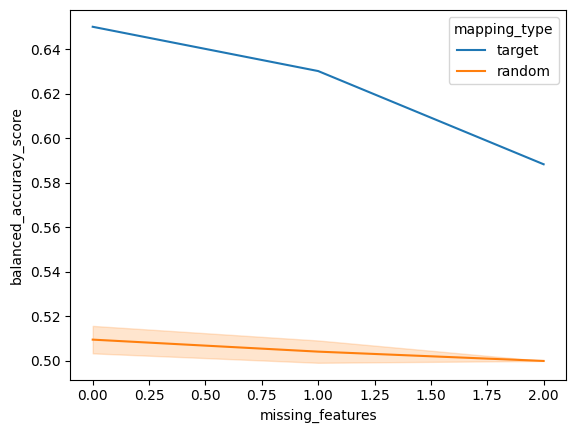

In [18]:
# target_encoded_data = data[data['ptype'] == 'target']
# print(target_encoded_data)
# plt.plot()
datap = data.copy()
datap = datap.rename({
    "ptype": "mapping_type",
    "score": "balanced_accuracy_score",
    "index": "missing_features"
}, axis='columns')
sns.lineplot(datap, x='missing_features', y='balanced_accuracy_score', hue='mapping_type', errorbar=('se', 2))

In [78]:
len(np.unique(preprop[2]['native-country']))

41

In [12]:
feature_order = list(reversed([
    'relationship',
    'occupation',
    'marital-status',
    'workclass',
    'race',
    'native-country'
]))

train_index, test_index = train_test_split(np.arange(len(y_data)), test_size=0.3)
y_train, y_test = y_data[train_index], y_data[test_index]

data = []

model = models[0][1]

for i in range(len(feature_order)):
    features = feature_order[i:]
    data.append({
        "score": test_permutation(
            features, 
            model, 
            target_encode, 
            train_index, 
            test_index, 
            y_train, 
            y_test, 
            balanced_accuracy_score
        ),
        "model": model,
        "ptype": "target",
        "index": i
    })
    
    for _ in range(30):
        data.append({
            "score": test_permutation(
                features, 
                model, 
                random_encode, 
                train_index, 
                test_index, 
                y_train, 
                y_test, 
                balanced_accuracy_score
            ),
            "model": model,
            "ptype": "random",
            "index": i
        })
        
data = pd.DataFrame(data)
data.to_csv('non-natural-ordinal.csv')


<AxesSubplot: xlabel='missing_features', ylabel='balanced_accuracy_score'>

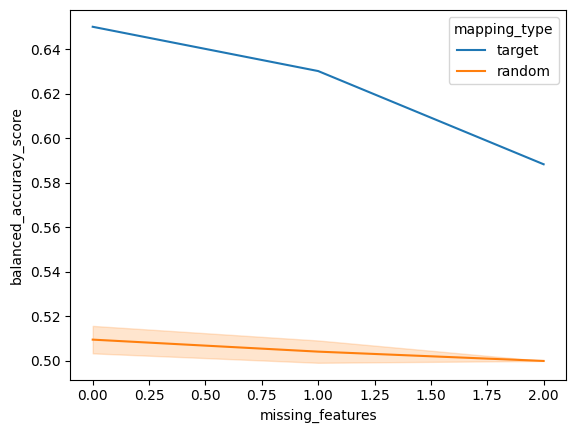

In [17]:
datap = data.copy()
datap = datap.rename({
    "ptype": "mapping_type",
    "score": "balanced_accuracy_score",
    "index": "missing_features"
}, axis='columns')
sns.lineplot(datap, x='missing_features', y='balanced_accuracy_score', hue='mapping_type', errorbar=('se', 2))

In [14]:
feature_order = list(reversed([
    'education',
    'age',
    'hours-per-week'
]))

train_index, test_index = train_test_split(np.arange(len(y_data)), test_size=0.3)
y_train, y_test = y_data[train_index], y_data[test_index]

data = []

model = models[0][1]

for i in range(len(feature_order)):
    features = feature_order[i:]
    data.append({
        "score": test_permutation(
            features, 
            model, 
            target_encode, 
            train_index, 
            test_index, 
            y_train, 
            y_test, 
            balanced_accuracy_score
        ),
        "model": model,
        "ptype": "target",
        "index": i
    })
    
    for _ in range(30):
        data.append({
            "score": test_permutation(
                features, 
                model, 
                random_encode, 
                train_index, 
                test_index, 
                y_train, 
                y_test, 
                balanced_accuracy_score
            ),
            "model": model,
            "ptype": "random",
            "index": i
        })
        
data = pd.DataFrame(data)
data.to_csv('natural-ordinal.csv')


<AxesSubplot: xlabel='missing_features', ylabel='balanced_accuracy_score'>

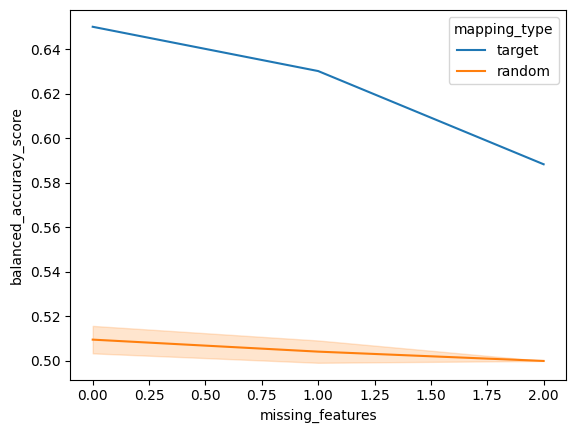

In [16]:
datap = data.copy()
datap = datap.rename({
    "ptype": "mapping_type",
    "score": "balanced_accuracy_score",
    "index": "missing_features"
}, axis='columns')
sns.lineplot(datap, x='missing_features', y='balanced_accuracy_score', hue='mapping_type', errorbar=('se', 2))

In [21]:
from cdt.causality.graph import SAM
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


feature_order = list(reversed([
    'relationship',
    'occupation',
    'education',
    'age',
    'hours-per-week',
    'marital-status',
    'workclass',
    'race',
    'native-country'
]))

# def test_permutation(features, model, permutation_type, train_index, test_index, y_train, y_test, metric):
target_encoded = (target_encode(x, train_index) for x in feature_order)

X = np.array(
    list(zip(*target_encoded))
)


scalar = StandardScaler().fit(X[train_index])
data = scalar.transform(X[train_index])

data = pd.DataFrame(data)


# Initialize and apply GES algorithm (Replace 'data' with your DataFrame variable)
model = SAM()
output_graph = model.predict(data)

# Visualization of the output graph
plt.figure(figsize=(12, 8))
nx.draw_networkx(output_graph, with_labels=True, node_color='skyblue', font_size=10, node_size=500)
plt.title("Causal Graph using SAM Algorithm")
plt.show()


Process Process-20:
Traceback (most recent call last):
  File "/home/koppd/.conda/envs/tf2/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/koppd/.conda/envs/tf2/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/koppd/.conda/envs/tf2/lib/python3.9/site-packages/cdt/utils/parallel.py", line 54, in worker_subprocess
    output = function(*args, **kwargs, device=device, idx=idx)
  File "/home/koppd/.conda/envs/tf2/lib/python3.9/site-packages/cdt/causality/graph/SAM.py", line 216, in run_SAM
    data = th.from_numpy(data).to(device)
  File "/home/koppd/.conda/envs/tf2/lib/python3.9/site-packages/torch/cuda/__init__.py", line 289, in _lazy_init
    raise AssertionError("Torch not compiled with CUDA enabled")
AssertionError: Torch not compiled with CUDA enabled


KeyboardInterrupt: 